In [1]:
!cd .. && mkdir build
!cd ../build/ && rm -rf *
!cd ../build && cmake \
  -DPYTHON_EXECUTABLE="$(which python)" \
  -DCMAKE_BUILD_TYPE=Release ..
!cd ../build && make install

mkdir: cannot create directory ‘build’: File exists
-- The C compiler identification is GNU 9.3.0
-- The CXX compiler identification is GNU 9.3.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
Release mode
-- Found PythonInterp: /home/jazzer/.pyenv/versions/3.6.10/bin/python (found version "3.6.10") 
-- Found PythonLibs: /home/jazzer/.pyenv/versions/3.6.10/lib/libpython3.6m.a
-- pybind11 v2.2.4
-- Performing Test HAS_FLTO
-- Performing Test HAS_FLTO - Success
-- LTO enabled
CMAKE_INSTALL_PREFIX=/home/jazzer/Facultad/metodos_numericos_3/mt/tp3
-- Configuring done
-- Generating done
-- Build files have been written to: /home/jazzer/

/home/jazzer/Facultad/metodos_numericos_3/mt/tp3/notebooks
Python 3.6.10
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240000 entries, 0 to 239999
Data columns (total 24 columns):
id                            240000 non-null int64
titulo                        234613 non-null object
descripcion                   238381 non-null object
tipodepropiedad               239954 non-null object
direccion                     186928 non-null object
ciudad                        239628 non-null object
provincia                     239845 non-null object
antiguedad                    196445 non-null float64
habitaciones                  217529 non-null float64
garages                       202235 non-null float64
banos                         213779 non-null float64
metroscubiertos               222600 non-null float64
metrostotales                 188533 non-null float64
idzona                        211379 non-null float64
lat                           116512 non-null float64
lng           

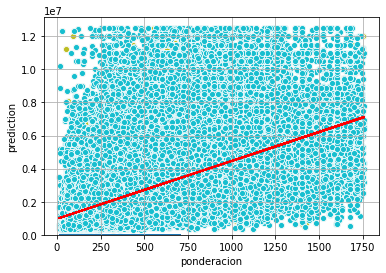

In [9]:
import pandas as pd
import numpy as np
import time
import math
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.metrics import *

!pwd
!python --version
import metnum

def new_feature(row):
    return row['metroscubiertos']*row['banos']

def calculate_metrics(variable_to_predict, df_old):
    df = df_old.copy(deep=True)
    df = df[df['prediction'].notna()]
    df = df[df['prediction']>-1]

    return (math.sqrt(mean_squared_error(df[variable_to_predict], df['prediction'])),
            math.sqrt(mean_squared_log_error(df[variable_to_predict]+1, df['prediction']+1)))

def experiment(percentage_of_training_cases,
         variable_to_predict,
         variables_to_study,
         seed, 
         df_old,
         data):
    df = df_old.copy(deep=True)
    
    t0 = time.time()
    
    df = df[0:].sample(frac=1, random_state=seed)
    
    #cleanup
    df = df[df[variable_to_predict].notna()]
    for var in variables_to_study:
        df = df[df[var].notna()]
        
    TOTAL_TRAIN_CASES = int(percentage_of_training_cases*len(df))

    df_prediction = df[TOTAL_TRAIN_CASES:].copy(deep=True)

    df = df[:TOTAL_TRAIN_CASES]

    x_train, y_train = df[variables_to_study].values, df[variable_to_predict].values
    x_predict, y_predict = df_prediction[variables_to_study].values, df_prediction[variable_to_predict].values
    
    x_train = x_train.reshape(len(x_train),len(variables_to_study))
    y_train = y_train.reshape(len(y_train),1)
    x_predict = x_predict.reshape(len(x_predict),len(variables_to_study))
    y_predict = y_predict.reshape(len(y_predict),1)

    linear_regressor = metnum.LinearRegression()
    linear_regressor.fit(x_train, y_train)
    df_prediction['prediction'] = linear_regressor.predict(x_predict)

    t1 = time.time()
    total_time = (t1-t0)
    
    rmse, rmsle = calculate_metrics(variable_to_predict, df_prediction)
    data['rmse'].append(rmse)
    data['rmsle'].append(rmsle)
    data['percentage_of_train_cases'].append(percentage_of_training_cases)
    data['time'].append(total_time)
    
    if(len(variables_to_study)==1):
        sns.scatterplot(data=df, x=variables_to_study[0], y=variable_to_predict)
        sns.lineplot(data=df_prediction, x=variables_to_study[0], y='prediction', color='red')
    elif(len(variables_to_study)==2):
        fig = plt.figure(figsize=(20,10))
        ax = fig.gca(projection='3d')
        ax.set_xlabel('X', fontsize=15, rotation=150)
        ax.set_ylabel('Y')
        ax.set_zlabel(r'Z', fontsize=15)
        ax.scatter(df_prediction[variables_to_study[0]],
                   df_prediction[variables_to_study[1]],
                   df_prediction['prediction'], c='skyblue', s=60)
        ax.plot_trisurf(df_prediction[variables_to_study[0]], 
                        df_prediction[variables_to_study[1]], 
                        df_prediction['prediction'], cmap=plt.cm.viridis, linewidth=0.2)
        plt.show()
    return df_prediction

df = pd.read_csv('../data/train.csv')
df_con_nueva_feature = df.copy(deep=True)

df_con_nueva_feature['ponderacion'] = df_con_nueva_feature.apply(lambda row: new_feature(row),axis=1)

print(df_con_nueva_feature.info())
df_con_nueva_feature['ponderacion'].hist()

d = {'rmse' : [], 'rmsle' : [], 'percentage_of_train_cases' : [], 'time' : []}

folder='./experimento_ponderacion_no_lineal_{}'.format(int(time.time()))
os.mkdir(folder)

for j in np.arange(1,11,1):
    for i in np.arange(0.6, 0.99, 0.05):
        print(i)
        df_prediction_no_lineal = experiment(i, 'precio', ['ponderacion',
                                                           'escuelascercanas','centroscomercialescercanos',
                                                           'garages'], j*int(i*100), df_con_nueva_feature, d)
        df_prediction_no_lineal.to_csv(folder+'/prediction_'+str(j)+'_'+str(i)+'.csv', encoding='utf-8', index=False)
        print('\n--------------\n')

(pd.DataFrame(data=d)
   .to_csv(folder+'/error.csv', encoding='utf-', index=False))

# for j in np.arange(1,11,1):
#     for i in np.arange(0.6, 0.99, 0.05):
#         print(i)
#         df_prediction_no_lineal = experiment(i, 'precio', ['metroscubiertos','banos',
#                                                            'escuelascercanas','centroscomercialescercanos',
#                                                            'garages'], j*int(i*100), df_con_nueva_feature, d)
#         df_prediction_no_lineal.to_csv(folder+'/prediction_'+str(j)+'_'+str(i)+'.csv', encoding='utf-8', 
#                                        index=False)
#         print('\n--------------\n')

# (pd.DataFrame(data=d)
#    .to_csv(folder+'/error.csv', encoding='utf-', index=False))